# Long Trades Analysis

In [1]:
import sys

import pandas as pd

sys.path.append("../")

In [2]:
df = pd.read_parquet("../tests/triple_barrier/integration/output/test-apply-long-no-dynamic-exit.parquet")

<Axes: xlabel='date-time'>

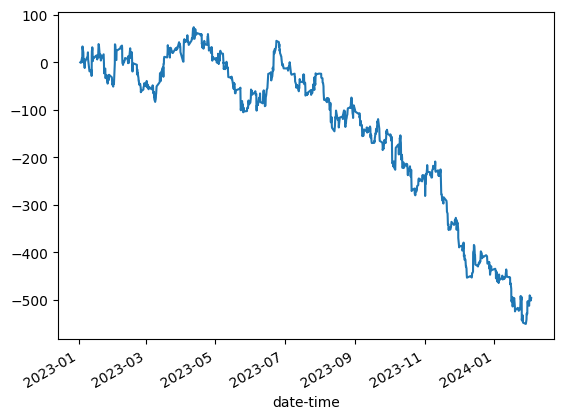

In [3]:
df["profit"].cumsum().plot()

<Axes: >

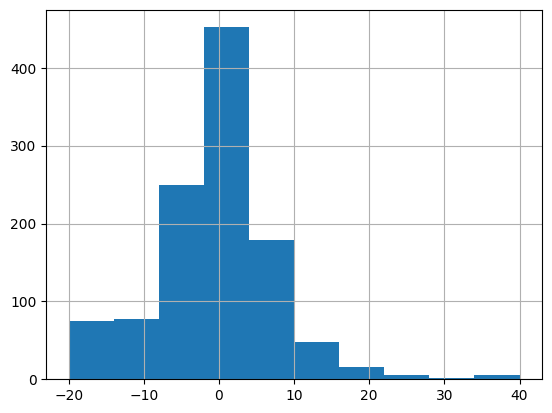

In [4]:
df["profit"].hist()

In [5]:
mask = df["profit"] > 0
print("Win trades profit", df[mask]["profit"].sum())
print("Lose trades profit", df[~mask]["profit"].sum())
print("Total profit", df["profit"].sum())

Win trades profit 2992.6
Lose trades profit -3488.8
Total profit -496.19999999999993


In [6]:
df.groupby("close-type")["profit"].sum()

close-type
stop-loss         -1120.0
take-profit         160.0
time-expiration     463.8
Name: profit, dtype: float64

## Take Profit Check

In [7]:
mask = df["close-type"]=="take-profit"
df[mask]

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-12 10:10:00,1.07694,1.07724,1.07659,1.07719,1.0,1.08094,2023-01-12 10:25:00,take-profit,40.0
2023-02-01 19:30:00,1.09897,1.09928,1.09894,1.09926,1.0,1.10297,2023-02-01 20:10:00,take-profit,40.0
2023-06-21 10:45:00,1.09145,1.09218,1.09108,1.09218,1.0,1.09545,2023-06-21 11:35:00,take-profit,40.0
2023-12-13 16:05:00,1.08351,1.08402,1.08282,1.08353,1.0,1.08751,2023-12-13 16:35:00,take-profit,40.0


## Stop Loss Check

In [8]:
mask = df["close-type"]=="stop-loss"
df[mask].head()

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-13 08:00:00,1.08452,1.08459,1.08364,1.08364,1.0,1.08252,2023-01-13 08:20:00,stop-loss,-20.0
2023-01-19 12:05:00,1.08157,1.08192,1.08149,1.08152,1.0,1.07957,2023-01-19 12:30:00,stop-loss,-20.0
2023-01-23 04:05:00,1.09172,1.09272,1.09077,1.09116,1.0,1.08972,2023-01-23 04:25:00,stop-loss,-20.0
2023-01-23 06:55:00,1.09198,1.09203,1.09117,1.09120,1.0,1.08998,2023-01-23 07:30:00,stop-loss,-20.0
2023-01-24 11:10:00,1.08671,1.08700,1.08664,1.08689,1.0,1.08471,2023-01-24 11:45:00,stop-loss,-20.0


## Check Time Expirarion

In [9]:
mask = df["close-type"]=="time-expiration"
df[mask].head()

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-02 08:05:00,1.06856,1.06857,1.06836,1.06843,1.0,1.06850,2023-01-02 08:55:00,time-expiration,-0.6
2023-01-02 20:45:00,1.06709,1.06718,1.06692,1.06716,1.0,1.06699,2023-01-02 21:35:00,time-expiration,-1.0
2023-01-02 23:50:00,1.06747,1.06781,1.06740,1.06755,1.0,1.06752,2023-01-03 00:40:00,time-expiration,0.5
2023-01-03 14:45:00,1.05485,1.05494,1.05404,1.05409,1.0,1.05547,2023-01-03 15:35:00,time-expiration,6.2
2023-01-03 21:25:00,1.05567,1.05580,1.05556,1.05561,1.0,1.05604,2023-01-03 22:15:00,time-expiration,3.7


<Axes: xlabel='date-time'>

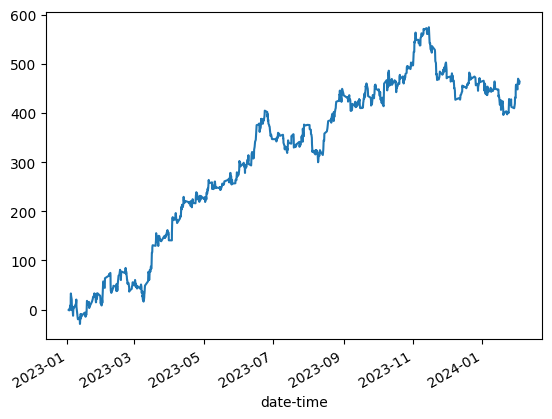

In [10]:
mask = df["close-type"]=="time-expiration"
df[mask]["profit"].cumsum().plot()

<Axes: >

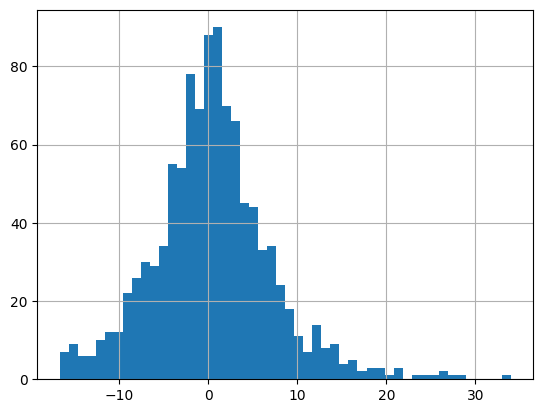

In [11]:
df[mask]["profit"].hist(bins=50)

## Plot Trades

In [12]:
from triple_barrier.types import TradeSide
import triple_barrier.constants as const
from triple_barrier.plots import PlotTripleBarrier
from triple_barrier.orders import Orders
from triple_barrier.trade_labeling import Labeler

### Open Original Data Set

In [13]:
file_name = f"{const.ROOT_FOLDER}/tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv"
price = pd.read_csv(file_name, index_col="time", parse_dates=True, names=["time", "open", "high", "low", "close", "volume"], header=0)
price["mva-12"] = price["close"].rolling(12).mean()
price["mva-24"] = price["close"].rolling(24).mean()
price.dropna(inplace=True)

In [14]:
price.head()

,open,high,low,close,volume,mva-12,mva-24
time,,,,,,,
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.070519,1.070254
2023-01-02 02:00:00,1.07044,1.07052,1.07041,1.07047,86.19,1.070523,1.070279
2023-01-02 02:05:00,1.07044,1.07051,1.06967,1.06993,367.80,1.070482,1.070284
2023-01-02 02:10:00,1.06994,1.07005,1.06904,1.07001,259.76,1.070445,1.070290
2023-01-02 02:15:00,1.07001,1.07011,1.06997,1.07008,174.19,1.070401,1.070300


### Plot Hit Long

In [15]:

PIP_POSITION = 4
TIME_BARRIER_PERIODS = 10
TAKE_PROFIT_WIDTH = 40
STOP_LOSS_WIDTH = 20
PIP_DECIMAL_POSITION = 4


# Uncomment the line you want to plot

# OPEN_DATE = "2023-01-12 10:10:00"  # case 1 take profit
# OPEN_DATE = "2023-02-01 19:30:00"  # case 2 take profit
# OPEN_DATE = "2023-06-21 10:45:00"  # case 3 take profit

# OPEN_DATE = "2023-01-13 08:00:00"  # case 4 stop loss
# OPEN_DATE = "2023-01-19 12:05:00"  # case 5 stop loss
# OPEN_DATE = "2023-01-23 04:05:00"  # case 6 stop loss

# OPEN_DATE = "2023-01-02 08:05:00"  # case 7 time expiration
# OPEN_DATE = "2023-01-02 20:45:00"  # case 8 time expiration
OPEN_DATE = "2023-01-03 14:45:00"  #case 9 time expiration


row_index = 2
box_setup = Orders()

box_setup.open_time = str(df.loc[OPEN_DATE].name)
box_setup.open_price = df.loc[box_setup.open_time]["open"]
box_setup.take_profit_width = TAKE_PROFIT_WIDTH
box_setup.stop_loss_width = STOP_LOSS_WIDTH
box_setup.time_limit = price[box_setup.open_time:].index[TIME_BARRIER_PERIODS]
box_setup.trade_side = TradeSide.BUY
box_setup.pip_decimal_position = PIP_DECIMAL_POSITION

In [16]:
print(box_setup)


        open time: 2023-01-03 14:45:00
        open price: 1.05485
        trade side: BUY
        stop loss : 20
        take profit : 40
        time limit : 2023-01-03 15:35:00
        pip position : 4
        


In [17]:
barrier_builder = Labeler(open_price=price.open,
                               high_price=price.high,
                               low_price=price.low,
                               close_price=price.close,
                               dynamic_exit=None,
                               box_setup=box_setup
                               )
barrier_builder.compute()
print(barrier_builder.orders_hit)


        
First Hit: 

        Hit type time-expiration
        Hit datetime 2023-01-03 15:35:00
        "Hit price 1.05547
        
Other hits 

        Datetime: 2023-01-04 04:30:00
        Level: 1.05885
        Type: take-profit
        

        Datetime: 2023-01-05 12:10:00
        Level: 1.05285
        Type: stop-loss
        

        Datetime: 2023-01-03 15:35:00
        Level: 1.05547
        Type: time-expiration
        


Plotting barrier for 100


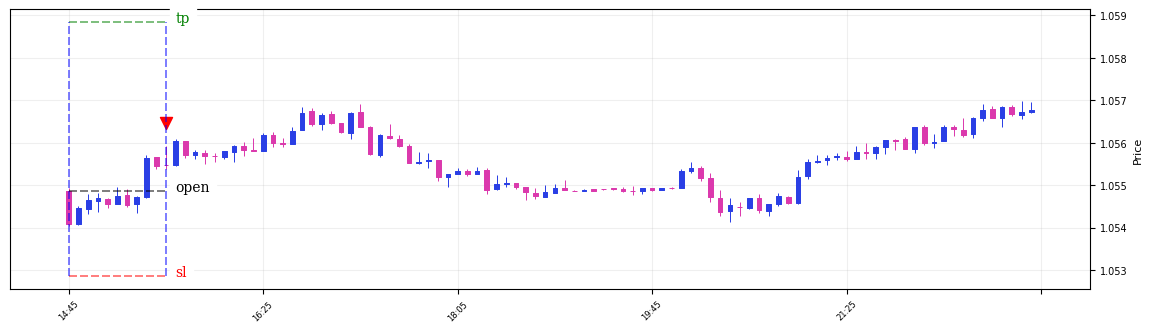

In [18]:
plot_tb = PlotTripleBarrier(open_price=price.open,
                           high_price=price.high,
                           low_price=price.low,
                           close_price=price.close,
                           pip_decimal_position=PIP_DECIMAL_POSITION,
                           periods_to_plot=100)
plot_tb.plot_multi_barrier(barrier_builder)